📁 Dataset structure:
   3_long_blade_rotor: 799 images
   3_short_blade_rotor: 800 images
   Bird: 800 images
   Bird+mini-helicopter: 815 images
   drone: 835 images
   rc_plane: 800 images

🔄 Loading images...
Loaded 799 images from 3_long_blade_rotor
Loaded 800 images from 3_short_blade_rotor
Loaded 800 images from Bird
Loaded 815 images from Bird+mini-helicopter
Loaded 835 images from drone
Loaded 800 images from rc_plane

📊 Loading Summary: 4849 images loaded, 0 failed
✅ Dataset loaded: 4849 images, (224, 224, 3) shape
📊 Train: 3394, Test: 1455

MAIN VGG16 MODEL TRAINING
Loading VGG16 with ImageNet weights...
⚠️ Failed to load pre-trained weights: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno -3] Temporary failure in name resolution
Loading VGG16 without pre-trained weights...
✅ Loaded VGG16 without pre-trained weights
📋 Model Summary:
   Total parameters: 27,693,126
   Trai

I0000 00:00:1748847905.904650      76 service.cc:148] XLA service 0x7c627000f340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748847905.905463      76 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748847906.280845      76 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/107 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.0859 - loss: 1.7921  

I0000 00:00:1748847915.318106      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


107/107 ━━━━━━━━━━━━━━━━━━━━ 55s 383ms/step - accuracy: 0.1592 - loss: 1.7924 - val_accuracy: 0.2144 - val_loss: 1.7644
Epoch 2/70
107/107 ━━━━━━━━━━━━━━━━━━━━ 35s 303ms/step - accuracy: 0.2553 - loss: 1.7531 - val_accuracy: 0.2564 - val_loss: 1.5931
Epoch 3/70
107/107 ━━━━━━━━━━━━━━━━━━━━ 35s 304ms/step - accuracy: 0.3314 - loss: 1.5859 - val_accuracy: 0.3704 - val_loss: 1.4301
Epoch 4/70
107/107 ━━━━━━━━━━━━━━━━━━━━ 35s 306ms/step - accuracy: 0.3554 - loss: 1.4519 - val_accuracy: 0.3677 - val_loss: 1.3814
Epoch 5/70
107/107 ━━━━━━━━━━━━━━━━━━━━ 35s 305ms/step - accuracy: 0.4079 - loss: 1.3888 - val_accuracy: 0.4550 - val_loss: 1.3154
Epoch 6/70
107/107 ━━━━━━━━━━━━━━━━━━━━ 34s 302ms/step - accuracy: 0.4058 - loss: 1.3404 - val_accuracy: 0.4639 - val_loss: 1.2644
Epoch 7/70
107/107 ━━━━━━━━━━━━━━━━━━━━ 35s 308ms/step - accuracy: 0.4356 - loss: 1.3189 - val_accuracy: 0.4550 - val_loss: 1.2264
Epoch 8/70
107/107 ━━━━━━━━━━━━━━━━━━━━ 35s 306ms/step - accuracy: 0.4561 - loss: 1.2691 - val

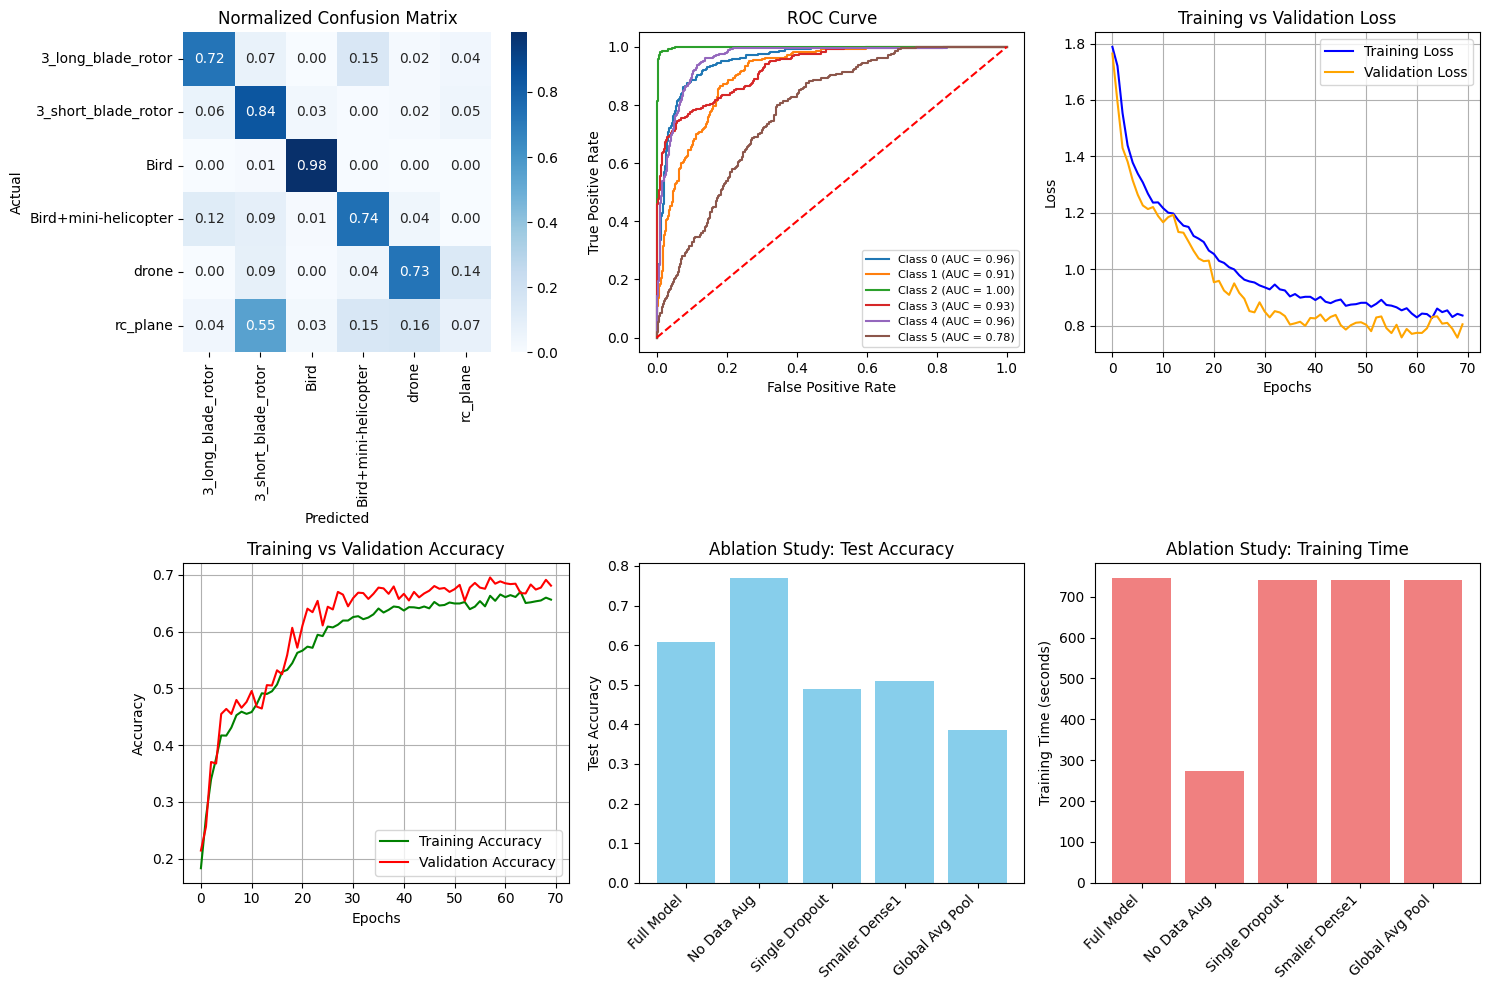


EXPLAINABILITY ANALYSIS
🔍 Running SHAP analysis...
⚠️ SHAP analysis failed: 'tuple' object has no attribute 'as_list'
🔍 Running LIME analysis...


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
✅ LIME analysis completed

FINAL SUMMARY

🎯 MAIN MODEL PERFORMANCE:
   • Test Accuracy: 68.11%
   • F1 Score: 0.6503
   • Training Time: 41.1 minutes
   • Inference Speed: 4.6ms per sample

🧪 ABLATION STUDY:
   • Best variant: No Data Aug (0.7691)
   • Performance range: 0.3849 - 0.7691

💡 RECOMMENDATIONS:
   • Model performance: Needs Improvement
   • Consider no data aug configuration for best results
   • Explainability tools available
    


In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

# Optional explainability libraries - will handle import errors gracefully
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Install with: pip install shap")

try:
    from lime import lime_image
    from skimage.segmentation import mark_boundaries
    LIME_AVAILABLE = True
except ImportError:
    LIME_AVAILABLE = False
    print("LIME not available. Install with: pip install lime-ml scikit-image")

# Category Mapping
categories = {
    '3_long_blade_rotor': 0,
    '3_short_blade_rotor': 1,
    'Bird': 2,
    'Bird+mini-helicopter': 3,
    'drone': 4,
    'rc_plane': 5
}

def check_dataset_structure(dataset_path):
    """Check if dataset structure is correct"""
    if not os.path.exists(dataset_path):
        print(f"❌ Dataset path does not exist: {dataset_path}")
        return False
    
    print(f"📁 Dataset structure:")
    missing_categories = []
    for category in categories.keys():
        category_path = os.path.join(dataset_path, category)
        if os.path.exists(category_path):
            count = len([f for f in os.listdir(category_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"   {category}: {count} images")
        else:
            missing_categories.append(category)
            print(f"   {category}: ❌ MISSING")
    
    if missing_categories:
        print(f"❌ Missing categories: {missing_categories}")
        return False
    return True

def load_images_from_folder(folder):
    """Load and preprocess images with error handling"""
    images, labels = [], []
    total_loaded = 0
    total_failed = 0
    
    for category, label in categories.items():
        category_folder = os.path.join(folder, category)
        if not os.path.exists(category_folder):
            print(f"Warning: {category_folder} does not exist!")
            continue
            
        category_loaded = 0
        for filename in os.listdir(category_folder):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(category_folder, filename)
                    img = load_img(img_path, target_size=(224, 224))
                    img_array = img_to_array(img) / 255.0
                    images.append(img_array)
                    labels.append(label)
                    category_loaded += 1
                    total_loaded += 1
                except Exception as e:
                    print(f"Error loading {filename}: {e}")
                    total_failed += 1
        
        print(f"Loaded {category_loaded} images from {category}")
    
    print(f"\n📊 Loading Summary: {total_loaded} images loaded, {total_failed} failed")
    return np.array(images), np.array(labels)

def create_vgg16_model_safe():
    """Create VGG16 model with fallback for network issues"""
    try:
        # Try loading with pre-trained weights
        print("Loading VGG16 with ImageNet weights...")
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        print("✅ Successfully loaded pre-trained VGG16")
    except Exception as e:
        print(f"⚠️ Failed to load pre-trained weights: {e}")
        print("Loading VGG16 without pre-trained weights...")
        base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
        print("✅ Loaded VGG16 without pre-trained weights")
    
    base_model.trainable = False
    return base_model

def build_model(base_model):
    """Build the complete model"""
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(6, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    learning_rate = 0.0005
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def create_vgg16_variant(use_data_aug=True, use_two_dropout=True, dense1_units=512, dense2_units=256, use_flatten=True):
    """Create VGG16 model variants for ablation study"""
    try:
        base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    except:
        base = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
    
    base.trainable = False
    
    # Choose pooling method
    if use_flatten:
        x = Flatten()(base.output)
    else:
        x = GlobalAveragePooling2D()(base.output)
    
    # First dense layer
    x = Dense(dense1_units, activation='relu')(x)
    x = Dropout(0.4)(x)
    
    # Second dense layer (ablation component)
    if use_two_dropout:
        x = Dense(dense2_units, activation='relu')(x)
        x = Dropout(0.4)(x)
    
    outputs = Dense(6, activation='softmax')(x)
    
    model = Model(inputs=base.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                 loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def main():
    # Configuration
    dataset_path = "/kaggle/input/micro-doppler-dataset/new1"  # Update this path
    
    # Check dataset structure
    if not check_dataset_structure(dataset_path):
        print("❌ Please fix dataset structure before continuing")
        return
    
    # Load and preprocess data
    print("\n🔄 Loading images...")
    X, y = load_images_from_folder(dataset_path)
    
    if len(X) == 0:
        print("❌ No images loaded. Please check your dataset path and structure.")
        return
    
    print(f"✅ Dataset loaded: {X.shape[0]} images, {X.shape[1:]} shape")
    
    # Convert labels to categorical
    y = to_categorical(y, num_classes=6)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    print(f"📊 Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")
    
    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    datagen.fit(X_train)
    
    # ================== MAIN MODEL TRAINING ==================
    print("\n" + "="*60)
    print("MAIN VGG16 MODEL TRAINING")
    print("="*60)
    
    start_time = time.time()
    
    # Build model
    base_model = create_vgg16_model_safe()
    model = build_model(base_model)
    
    print(f"📋 Model Summary:")
    print(f"   Total parameters: {model.count_params():,}")
    print(f"   Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
    
    # Train Model
    training_start = time.time()
    epochs = 70
    
    print(f"🚀 Starting training for {epochs} epochs...")
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32), 
        epochs=epochs, 
        validation_data=(X_test, y_test),
        verbose=1
    )
    
    training_time = time.time() - training_start
    total_time = time.time() - start_time
    
    # Save Model
    model.save("vgg16_micro_doppler.h5")
    print("✅ Model saved as vgg16_micro_doppler.h5")
    
    # Inference time analysis
    inference_start = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - inference_start
    
    print(f"\n📊 TIME ANALYSIS RESULTS:")
    print(f"Model Building Time: {training_start - start_time:.2f} seconds")
    print(f"Training Time: {training_time:.2f} seconds ({training_time/60:.1f} minutes)")
    print(f"Total Time: {total_time:.2f} seconds")
    print(f"Inference Time: {inference_time:.2f} seconds")
    print(f"Average Inference Time per Sample: {inference_time/len(X_test):.4f} seconds")
    
    # ================== ABLATION STUDY ==================
    print("\n" + "="*60)
    print("ABLATION STUDY")
    print("="*60)
    
    # Define ablation experiments
    ablation_experiments = {
        'Full Model': {'use_data_aug': True, 'use_two_dropout': True, 'dense1_units': 512, 'dense2_units': 256, 'use_flatten': True},
        'No Data Aug': {'use_data_aug': False, 'use_two_dropout': True, 'dense1_units': 512, 'dense2_units': 256, 'use_flatten': True},
        'Single Dropout': {'use_data_aug': True, 'use_two_dropout': False, 'dense1_units': 512, 'dense2_units': 256, 'use_flatten': True},
        'Smaller Dense1': {'use_data_aug': True, 'use_two_dropout': True, 'dense1_units': 256, 'dense2_units': 256, 'use_flatten': True},
        'Global Avg Pool': {'use_data_aug': True, 'use_two_dropout': True, 'dense1_units': 512, 'dense2_units': 256, 'use_flatten': False},
    }
    
    ablation_results = {}
    
    for exp_name, config in ablation_experiments.items():
        print(f"\n🧪 Training {exp_name}...")
        
        start_time = time.time()
        
        # Create model variant
        variant_model = create_vgg16_variant(
            use_two_dropout=config['use_two_dropout'],
            dense1_units=config['dense1_units'],
            dense2_units=config['dense2_units'],
            use_flatten=config['use_flatten']
        )
        
        # Choose training data based on data augmentation setting
        if config['use_data_aug']:
            variant_history = variant_model.fit(
                datagen.flow(X_train, y_train, batch_size=32),
                epochs=20,
                validation_data=(X_test, y_test),
                verbose=0
            )
        else:
            variant_history = variant_model.fit(
                X_train, y_train,
                epochs=20,
                batch_size=32,
                validation_data=(X_test, y_test),
                verbose=0
            )
        
        # Evaluate
        loss, accuracy = variant_model.evaluate(X_test, y_test, verbose=0)
        training_time_var = time.time() - start_time
        
        ablation_results[exp_name] = {
            'test_accuracy': accuracy,
            'test_loss': loss,
            'training_time': training_time_var,
            'config': config
        }
        
        print(f"   Test Accuracy: {accuracy:.4f}")
        print(f"   Training Time: {training_time_var:.2f}s")
    
    # Display ablation results
    print(f"\n📊 ABLATION STUDY RESULTS:")
    print("-" * 80)
    print(f"{'Model Variant':<20} {'Test Acc':<10} {'Test Loss':<12} {'Train Time':<12}")
    print("-" * 80)
    
    for exp_name, results in ablation_results.items():
        print(f"{exp_name:<20} {results['test_accuracy']:<10.4f} {results['test_loss']:<12.4f} "
              f"{results['training_time']:<12.2f}")
    
    # ================== MODEL EVALUATION ==================
    print("\n" + "="*60)
    print("MAIN MODEL EVALUATION")
    print("="*60)
    
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Classification Report
    report = classification_report(y_true, y_pred_classes, target_names=categories.keys(), output_dict=True)
    print(classification_report(y_true, y_pred_classes, target_names=categories.keys()))
    
    # Calculate additional metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
    accuracy = report['accuracy']
    
    print(f"\n📊 MAIN MODEL PERFORMANCE:")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Confusion Matrix
    plt.subplot(2, 3, 1)
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=list(categories.keys()), yticklabels=list(categories.keys()))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Normalized Confusion Matrix")
    
    # ROC Curve
    plt.subplot(2, 3, 2)
    for i in range(6):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(fontsize=8)
    
    # Training Loss
    plt.subplot(2, 3, 3)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Training Accuracy
    plt.subplot(2, 3, 4)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Ablation Results
    plt.subplot(2, 3, 5)
    exp_names = list(ablation_results.keys())
    accuracies = [ablation_results[name]['test_accuracy'] for name in exp_names]
    plt.bar(range(len(exp_names)), accuracies, color='skyblue')
    plt.xticks(range(len(exp_names)), exp_names, rotation=45, ha='right')
    plt.ylabel('Test Accuracy')
    plt.title('Ablation Study: Test Accuracy')
    
    # Training Times
    plt.subplot(2, 3, 6)
    train_times = [ablation_results[name]['training_time'] for name in exp_names]
    plt.bar(range(len(exp_names)), train_times, color='lightcoral')
    plt.xticks(range(len(exp_names)), exp_names, rotation=45, ha='right')
    plt.ylabel('Training Time (seconds)')
    plt.title('Ablation Study: Training Time')
    
    plt.tight_layout()
    plt.show()
    
    # ================== EXPLAINABILITY (OPTIONAL) ==================
    if SHAP_AVAILABLE or LIME_AVAILABLE:
        print("\n" + "="*60)
        print("EXPLAINABILITY ANALYSIS")
        print("="*60)
        
        # Select samples for explanation
        sample_size = min(5, len(X_test))
        X_explain = X_test[:sample_size]
        
        if SHAP_AVAILABLE:
            try:
                print("🔍 Running SHAP analysis...")
                background = X_train[:10]  # Small background set
                explainer = shap.DeepExplainer(model, background)
                shap_values = explainer.shap_values(X_explain)
                print("✅ SHAP analysis completed")
            except Exception as e:
                print(f"⚠️ SHAP analysis failed: {e}")
        
        if LIME_AVAILABLE:
            try:
                print("🔍 Running LIME analysis...")
                explainer_lime = lime_image.LimeImageExplainer()
                
                # Analyze one sample
                def model_predict_wrapper(images):
                    return model.predict(images)
                
                explanation = explainer_lime.explain_instance(
                    X_explain[0], 
                    model_predict_wrapper, 
                    top_labels=3, 
                    hide_color=0, 
                    num_samples=50
                )
                print("✅ LIME analysis completed")
            except Exception as e:
                print(f"⚠️ LIME analysis failed: {e}")
    
    # ================== FINAL SUMMARY ==================
    best_variant = max(ablation_results.keys(), key=lambda x: ablation_results[x]['test_accuracy'])
    
    print(f"\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)
    print(f"""
🎯 MAIN MODEL PERFORMANCE:
   • Test Accuracy: {accuracy * 100:.2f}%
   • F1 Score: {f1:.4f}
   • Training Time: {training_time/60:.1f} minutes
   • Inference Speed: {inference_time/len(X_test)*1000:.1f}ms per sample

🧪 ABLATION STUDY:
   • Best variant: {best_variant} ({ablation_results[best_variant]['test_accuracy']:.4f})
   • Performance range: {min(r['test_accuracy'] for r in ablation_results.values()):.4f} - {max(r['test_accuracy'] for r in ablation_results.values()):.4f}

💡 RECOMMENDATIONS:
   • Model performance: {'Excellent' if accuracy > 0.9 else 'Good' if accuracy > 0.8 else 'Needs Improvement'}
   • Consider {best_variant.lower()} configuration for best results
   • Explainability tools {'available' if SHAP_AVAILABLE or LIME_AVAILABLE else 'not installed'}
    """)

if __name__ == "__main__":
    main()